<img src="images/DLI Header.png" alt="Header" style="width: 400px;"/>

A key use case of Natural Language Processing (NLP) - often regarded as the 'Holy Grail' of the field - is the ability to have a machine automatically translate text from one language to another.  This field is known as Machine Translation (MT) and when using Neural Networks and Deep Learning, it is usually called Neural Machine Translation (NMT).

Translation between languages is often difficult, even for a human.  Languages differ from each other in many ways, some more subtle than others.  An entire field of study - [Linguistic Typology](https://en.wikipedia.org/wiki/Linguistic_typology) - is dedicated to the understanding of how languages compare to each other.  As such, translation requires excellent knowledge of both source and target languages and their vagaries.

With the huge amounts of textual data available today, coupled with the compute power afforded by GPUs, it is only natural that NMT will see a huge rise in usage.  In fact, a number of well-known companies offer various products in this area.

In this lab we will focus on the following:

1. Building a Neural Machine Translation for converting human-readable date formats to machine-readable date formats
2. Improving the model using the concept of attention
3. Measuring the results of Neural Machine Translation using BLEU score
4. Real-world issues with Neural Machine Translation - Byte-Pair Encoding and Beam Search



# Machine Translation - Some Background

Machine translation belongs to a class of problems known as *Sequence-to-Sequence*. As the name implies, these problems deal with converting a *source sequence* $X$ into a *target sequence* $Y$.  Framing machine translation as a Sequence-to-Sequence (Seq-to-Seq) problem suggests that $X$ contains tokens (words or individual characters) in a source *language* while $Y$ are the equivalent tokens in the *target* language. Note that in the most general case, $X$ and $Y$ may have different lengths and equivalent tokens may even be in different locations, depending on the underlying word order of the languages involved.  

In the case of NMT, we would like to learn a function $f$ that maximizes the probability of a target sequence $Y$ given the source sequence $X$.  More formally:  given $X = \{x_1, x_2, ..., x_n\}$ and $Y = \{y_1, y_2, ..., y_m\}$ we would like $f$ to maximize the following conditional probability:

$$ P(y_i \space | \space y_{i-1}, ..., y_{1}, X) $$

for every $y_i$ in $Y$. There are two important points about this expression:
1.  We take into account information from the source sequence X.  In fact, we will use a function $g(X)$ which will *encode* X into some useful form.  
2.  The value of the current output token $y_i$ depends on all previous output tokens.  This is where the 'sequence' nature of the problem comes from.

We will be using a deep neural network to learn this function $f$.

## Lost in Translation

Imagine we are tasked with translating from a language such as German to English.

Below are 5 different results from different translation models. Although we don't know what the original sentence is, we can see that context can be easily figured out from the following examples when considered as a group. 

Translation A: I ask him whether he will once again make a stand-up comedy tour.

Translation B: I ask him if he will again make a stand-up comedy tour.

Translation C: I wonder him if he will ever make a booth up comedy tour.

Translation D: I ask him if he will ever make a stand-up comedy tour ever.

Translation E: I ask him whether he will again make a stand-up comedy tour.

It should be relatively easy to spot the worst translation, as it doesn't quite make sense in English. This is the result of a completely *literal* translation that does not take context into account.

Finding the worst translation was easy. On the other hand, identifying the best translation might differ from person to person since there's some subjectivity involved. Take Translation D for example: double use of 'ever' in one sentence probably lowers its score as a good English translation. Interestingly, the models producing the better translations all share an architectural detail. This is a key observation, and one that we will return to later when we discuss the *attention mechanism*.


Run the following cell to load all the modules we will be using in this lab.


In [2]:
from keras.layers import Embedding, Bidirectional
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
from keras.layers.merge import Multiply
from keras.utils import to_categorical
from keras.layers import TimeDistributed
from keras.backend import int_shape

import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
import pandas as pd

# Setup multiple versions of OpenSeq2Seq

import sys
from importlib import import_module

sys.path.append('old_s2s')
old_run = import_module('run')

sys.path.remove('old_s2s')
sys.path.append('OpenSeq2Seq')
new_run = import_module('run2')

def run_open_seq2seq(version, args):
    args = args.split(' ')
    args.insert(0, '')
    sys.argv = args
    version.main()
    
    
%matplotlib inline



Using TensorFlow backend.


The following code runs a pre-trained translation model.  Let it run, you can open up [baseline.txt](baseline.txt) to see the translation as it's being written. Once you see "I wonder him if he will ever make a booth up com@@ ed@@ y@@ tour ." as the output then you can press Stop button or Interrupt Kernel. It should take about 3.5 minutes to run to reach this line. Simply eliminate the @@ characters to get the sentences used above.

In [3]:
run_open_seq2seq(
    old_run, 
    '--config_file=old_s2s/example_configs/nmt_noatt.json --logdir=/dli/data/noatt --mode=infer --inference_out=baseline.txt')



>==================> Running in inference mode
>==================> Executing training mode
>==================> Creating data layer
>==================> Data layer created
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
>==================> Building graph on GPU:0
Instructions for updating:
seq_dim is deprecated, use seq_axis instead
Instructions for updating:
batch_dim is deprecated, use batch_axis instead
Inference Mode. Loss part of graph isn't built.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
>==================> Trying to restore from: /dli/data/noatt/model-59244
INFO:tensorflow:Restoring parameters from /dli/data/noatt/model-59244
>==================> Saving inference results to: baseline.txt
Prime Minister India and Japan met in Tokyo . </S> </S> </S>
Federal Government and Bun@@ de@@ stag not joined . </S> </S> </S> </S> </S> </S> </S> </S> </S> </S> </S> </S> </S> </S> 

KeyboardInterrupt: 

For this lab, we will begin with the Keras Deep-Learning framework with a Tensorflow backend. We will then switch to using [Open Seq2Seq](https://github.com/NVIDIA/OpenSeq2Seq), an NVIDIA open-source project for training sequence-to-sequence models.  In fact, the above code uses OpenSeq2Seq and by the end of this lab you will also be able to build your own machine translation models.


# Translating Human-Readable Dates into Machine-Readable Dates

We normally use NMT for translation between natural source and target languages.  In this section we will attempt a [toy problem](https://en.wikipedia.org/wiki/Toy_problem) in order to get a better intuition for the concepts involved.

Our model translates human-readable dates such as "the 29th of August 1958", "03/30/1968" and "24 JUNE 1987" into a standard, machine-readable form such as "1958-08-29", "1968-03-30" and "1987-06-24".  We will be using a date encoding of YYYY-MM-dd, where months precede days. Make sure that you understand how this problem fits into the framework of both machine translation and sequence-to-sequence. 

From the File menu above, click Open and select the file nmt_utils.py.  Look in the section titled FORMATS to see the various source text patterns we will use.

Our dataset is a corpus of 10000 human readable dates and their equivalent machine readable dates. Run the following cell to load the dataset.  In particular, note the `human_vocab` and `machine_vocab` variables.  These define our source and target *vocabularies*, making our problem a character-sequence to character-sequence problem.  

In [29]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = create_dataset(m)

# Maximum sequence length
max_sequence_length = 30


sources, targets = zip(*dataset)
sources = np.array([string_to_int(i, max_sequence_length, human_vocab) for i in sources])
targets = [string_to_int(t, max_sequence_length, machine_vocab) for t in targets]
targets = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), targets)))

100%|██████████| 10000/10000 [00:00<00:00, 17823.84it/s]


The following pieces of data have been loaded:

- max_sequence_length: the maximum length for a character sequence
- dataset: a list of (human-readable date, machine-readable date) pairs
- human_vocab: a mapping between all characters that are used in the human-readable dates to their integer index values
- machine_vocab: similar to `human_vocab`, a mapping between all characters used in the *machine-readable* dates to their integer index values
- inv_machine_vocab: an inverse mapping of `machine_vocab` (i.e., integer to character)
- sources: a processed version of the `dataset`'s human-readable dates.  Each character has been replaced by its index from `human_vocab`, and the resulting sequences have been padded to the length specified by `max_sequence_length`. 
- targets: a processed version of the `dataset`'s machine-readable dates.  Each character has been replaced the its index from `machine_vocab` and the sequences have been padded to the length specified by `max_sequence_length`.  Note also that the values have been 1-hot encoded, in order to use as labels in a model. 

The following cell selects a random value from `dataset`, and shows the way dates are encoded.  Run multiple times to see different values.

In [30]:
index = np.random.randint(m)

print("sources shape          : ", sources.shape)
print("targets shape          : ", targets.shape)
print("Length of human_vocab  : ", len(human_vocab))
print("Length of machine_vocab: ", len(machine_vocab))

print("\n")
print("Human-readable date                 : ", dataset[index][0])
print("Machine-readable date               : ", dataset[index][1])
print("Pre-processed human-readable date   : \n", sources[index])
print("Pre-processed machine-readable date : \n", targets[index]) # 1-hot encoded


sources shape          :  (10000, 30)
targets shape          :  (10000, 30, 15)
Length of human_vocab  :  62
Length of machine_vocab:  15


Human-readable date                 :  9/14/91
Machine-readable date               :  1991-09-14
Pre-processed human-readable date   : 
 [37 53  4 31 53 37  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
Pre-processed machine-readable date : 
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 

## Model architecture

An often-used architecture for seq-to-seq models - and hence, NMT - is known as `encoder-decoder`.  At a high level, the following steps are carried out by this network:

1.  Input - in our case, a human-readable date - is fed into the `encoder` part of the network.  The output of the encoder is one or many *state* vectors (also known as *context* vectors).  These state vectors encode a *representation* of the input data.  Each individual timestep may have its own context vector.  Alternatively, we can use the final state vector to represent the entire input.  Using the notation from the background section above:  given a sequence $X = \{h_1, h_2, ..., h_j\}$ - where $h_j$ is the output of the encoder DNN -  we can choose $g(X)$ to return all values in $X$ or simply choose $g(X) = h_j$.

2.  The output of the encoder is fed into the *decoder* part of the network.  In other words, the decoder receives the *representations* of the input that were learned by the encoder. The output of the decoder is the final output which in our case is the machine-readable date.  The decoder uses the data encoded in the state vectors to create the output.  

Since both the inputs and outputs of our model are sequences, it makes sense to use RNN's as the basis of both the encoder and decoder.  We can then train the encoder-decoder model in an end-to-end fashion so that both networks learn the relevant features.

### The Encoder Network

<img src="images/enc.png" style="width:600;height:300px;"> <br>
<caption><center> **Figure 1**: NMT Encoder Network </center></caption>

As shown in the figure, the input to the encoder is the text of the human-readable date.  Each character in the sequence is then run through an *embedding layer*.  The purpose of the embedding is to convert a sparse, 1-hot representation of the character to a dense representation which learns features about this character.  This representation is then fed into a bidirectional LSTM (Bi-LSTM).  The purpose of the Bi-LSTM is to look at a particular sequences both from front-to-back as well as from back-to-front.  In this way, the network creates a context for each character in the text that depends on both its past as well as its future.  Finally, we take the sequence of hidden states of the Bi-LSTM as our state vector list `enc_out`.

### The Decoder Network

<img src="images/dec.png" style="width:500;height:300px;"> <br>
<caption><center> **Figure 2**: NMT Decoder Network </center></caption>

The decoder receives `enc_out` as its input.  This sequence is itself run through an LSTM which produces a set of numbers.  We use the Softmax function to normalize these numbers so that we can treat them as probabilities.  It is then possible to choose the character which has the highest probability as the model output.  

**Exercise**: Implement the `model_simple_nmt()` described in the figure below. The LSTMs both use 32 units and the embedding dimension is 64. These functions might be useful: [Input()](https://keras.io/layers/core/#input), [Embedding()](https://keras.io/layers/embeddings/), [LSTM()](https://keras.io/layers/recurrent/#lstm), [Bidirectional()](https://keras.io/layers/wrappers/#bidirectional), [Dense()](https://keras.io/layers/core/#dense), [TimeDistributed()](https://keras.io/layers/wrappers/#timedistributed), [Model()](https://keras.io/models/model/).  

A solution is available in the file `solutions.py`.

In [31]:
def model_simple_nmt(human_vocab_size, machine_vocab_size, max_sequence_length = 20):
    """
    Simple Neural Machine Translation model
    
    Arguments:
    human_vocab_size -- size of the human vocabulary for dates, it will give us the size of the embedding layer
    machine_vocab_size -- size of the machine vocabulary for dates, it will give us the size of the output vector
    
    Returns:
    model -- model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define the input of your model with a shape (max_sequence_length,)
    
    inputs = Input((max_sequence_length,), name='input_layer')
    
    # Define the embedding layer. Embedding dimension should be 64 and input_length set to max_sequence_length.
    input_embed = Embedding(human_vocab_size, 64, input_length=max_sequence_length, name='Embedding_Layer')(inputs)
    
    # Encode the embeddings using a bidirectional LSTM
    enc_out = Bidirectional(LSTM(32, return_sequences=True), name='Encoder')(input_embed)
    
    # Decode the encoder output using an LSTM layer
    dec_out = LSTM(32, name='Decoder', return_sequences=True)(enc_out)
    
    ### END CODE HERE ###
    
    # Apply Dense layer to every time step
    output = TimeDistributed(Dense(machine_vocab_size, activation='softmax'))(dec_out)
    
    # Create model instance 
    model = Model(input=[inputs], output=output)

    return model

Run the following cell to create your `model` and compile it.

In [32]:
# Create model
model = model_simple_nmt(len(human_vocab), len(machine_vocab), max_sequence_length)

# Compile model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# See the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 30)                0         
_________________________________________________________________
Embedding_Layer (Embedding)  (None, 30, 64)            3968      
_________________________________________________________________
Encoder (Bidirectional)      (None, 30, 64)            24832     
_________________________________________________________________
Decoder (LSTM)               (None, 30, 32)            12416     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 15)            495       
Total params: 41,711
Trainable params: 41,711
Non-trainable params: 0
_________________________________________________________________


Run the following cell to train the model.

In [33]:
model.fit([sources[:8000]], targets[:8000], epochs=40, batch_size=128, validation_split=0.1, verbose=2)

Train on 7200 samples, validate on 800 samples
Epoch 1/40
 - 11s - loss: 1.1571 - acc: 0.6736 - val_loss: 0.8164 - val_acc: 0.7318
Epoch 2/40
 - 9s - loss: 0.7685 - acc: 0.7490 - val_loss: 0.7279 - val_acc: 0.7575
Epoch 3/40
 - 9s - loss: 0.7131 - acc: 0.7677 - val_loss: 0.6908 - val_acc: 0.7738
Epoch 4/40
 - 9s - loss: 0.6832 - acc: 0.7705 - val_loss: 0.6688 - val_acc: 0.7697
Epoch 5/40
 - 9s - loss: 0.6564 - acc: 0.7786 - val_loss: 0.6285 - val_acc: 0.7989
Epoch 6/40
 - 9s - loss: 0.6305 - acc: 0.7935 - val_loss: 0.5986 - val_acc: 0.8020
Epoch 7/40
 - 9s - loss: 0.6000 - acc: 0.8008 - val_loss: 0.5765 - val_acc: 0.8135
Epoch 8/40
 - 9s - loss: 0.5690 - acc: 0.8224 - val_loss: 0.5344 - val_acc: 0.8310
Epoch 9/40
 - 9s - loss: 0.5359 - acc: 0.8257 - val_loss: 0.5034 - val_acc: 0.8334
Epoch 10/40
 - 9s - loss: 0.5071 - acc: 0.8274 - val_loss: 0.4780 - val_acc: 0.8330
Epoch 11/40
 - 9s - loss: 0.4753 - acc: 0.8313 - val_loss: 0.5756 - val_acc: 0.8197
Epoch 12/40
 - 9s - loss: 0.4552 - ac

## Results

We seem to have good training and validation scores.  However, we measure score for individual *output characters* and not then entire output sequence.  In other words, if a particular digit is in the right place, we consider that a success regardless of other digits in the same output expression.  This is obviously problematic: April 5 is 04-05 and not 03-05.  Nevertheless, *any* date in April - even a wrong one - is probably better than a date in May.  We'll see a better way to measure translation quality later on.

In the meantime, let's see the results of our test set.





In [34]:
_,accuracy = model.evaluate([sources[8000:]], targets[8000:], batch_size=128,verbose=1)

2000/2000 [==============================] - 1s 476us/step


In [35]:
print(accuracy)

0.9435499997138977


Not bad!  

However, as we described above, we are probably not measuring things right.  Let's run some simple variations of a single date through the model to get an intuition for what the final sequences *really* look like.

In [41]:
EXAMPLES1 = ['03.3.2000', '03 03 2000', '03 mar 2000', '03 march 2000', 'march 03 2000', 'march 03, 2000' ]
EXAMPLES2 = ['04.4.2001', '04 04 2001', '03 apr 2000', '04 april 2001', 'april 04 2001', 'april 04, 2001' ]

def prediction_to_text(model_results):
    results = np.argmax(model_results[0], axis=-1)
    output = int_to_string(results, inv_machine_vocab)
    return ''.join(output).replace('<pad>','')

def run_examples(examples):
    for example in examples:
        print("source:", example)
        source = string_to_int(example, max_sequence_length, human_vocab)
        prediction = model.predict(np.array([source]))
        print("output:", prediction_to_text(prediction))
        print('******')
    
run_examples(EXAMPLES1)
print('---------')
run_examples(EXAMPLES2)

source: 03.3.2000
output: 2000-03-00
******
source: 03 03 2000
output: 2000-03-00
******
source: 03 mar 2000
output: 2000-03-03
******
source: 03 march 2000
output: 2000-03-03
******
source: march 03 2000
output: 2000-03-00
******
source: march 03, 2000
output: 2000-03-00
******
---------
source: 04.4.2001
output: 2000-04-05
******
source: 04 04 2001
output: 2000-04-05
******
source: 03 apr 2000
output: 2000-03-03
******
source: 04 april 2001
output: 2000-04-05
******
source: april 04 2001
output: 2000-09-04
******
source: april 04, 2001
output: 2000-09-04
******


There seem to be some commonalities to the mistakes that the model makes:
* Mistakes are more common when the human-readable input text is longer
* Mistakes are more common when information (such as the day or the year) have different positions in the sentence relative to each other.

We'll now try to get some generalizations for these intuitions.

### Effect of Input Length on Model Accuracy

For each instance of our training data, we'll perform the following steps:
* Calculate the length of the human-readable form
* Calculate whether the *entire* sequence is correct or not - that is, a single wrong digit makes the entire sequence wrong



In [42]:
# Import all data into a single data frame for convenience
df = pd.DataFrame(data=dataset[:8000], columns=['Source','Target'])
df['Source Length'] = df['Source'].apply(lambda x: len(x))

# Have the model predict all training data
model_predictions = model.predict(sources[:8000])
df['Actual'] = [prediction_to_text([x]) for x in model_predictions]

# Check if prediction matches ground truth
df['Is Correct'] = df['Actual'] == df['Target']

df.head()

,Source,Target,Source Length,Actual,Is Correct
0,05.06.94,1994-06-05,8,1994-06-04,False
1,"13 JULY, 1981",1981-07-13,13,1971-08-11,False
2,"12 october, 1995",1995-10-12,16,1993-10-22,False
3,06.12.16,2016-12-06,8,2016-12-16,False
4,"10 jan, 1972",1972-01-10,12,1972-01-10,True


We now group by the source length, and plot the percent of model predictions that matched the ground truth targets.  As discussed, we plot the accuracy for an *entire* prediction, not just a single character.

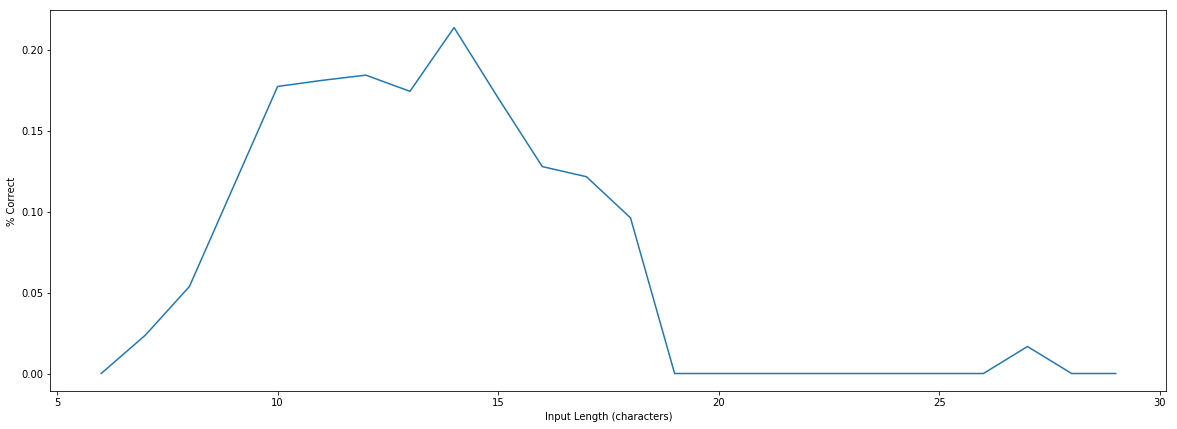

In [43]:
if not df['Is Correct'].any():
    print("Please re-train the model!")
else:
    ax = pd.crosstab(df['Source Length'], df['Is Correct'], normalize='index')[True].plot(kind='line', figsize=(20,7))
    ax.set_ylabel("% Correct")
    ax.set_xlabel("Input Length (characters)");

It would indeed appear that the model has difficulties when the source dates in human-readable format are longer.

### Effect of the Location of the Day on Model Accuracy

For each training instance, let's locate the day - i.e., the *3* in *July 3* in the machine-readable format.  This is easy, as we defined this format to be in a standard form.  We'll then locate that day in the human-readable format and try to determine whether this location has any bearing on the model accuracy.

In [44]:
day_location = 8 #  Recall that the machine-readable format is YYYY-MM-DD.  We look for the index where DD begins.

In [45]:
location_data = []
for x in df.iterrows():
    source = x[1].Source
    day_value = x[1].Target[day_location:day_location+2]
    if day_value[0] == '0':
        day_value = day_value[1]
    day_index = source.find(day_value)
        
    location_data.append((day_index))
    
location_data = np.array(location_data)

df['Day Location'] = location_data


df.head()

,Source,Target,Source Length,Actual,Is Correct,Day Location
0,05.06.94,1994-06-05,8,1994-06-04,False,1
1,"13 JULY, 1981",1981-07-13,13,1971-08-11,False,0
2,"12 october, 1995",1995-10-12,16,1993-10-22,False,0
3,06.12.16,2016-12-06,8,2016-12-16,False,1
4,"10 jan, 1972",1972-01-10,12,1972-01-10,True,0


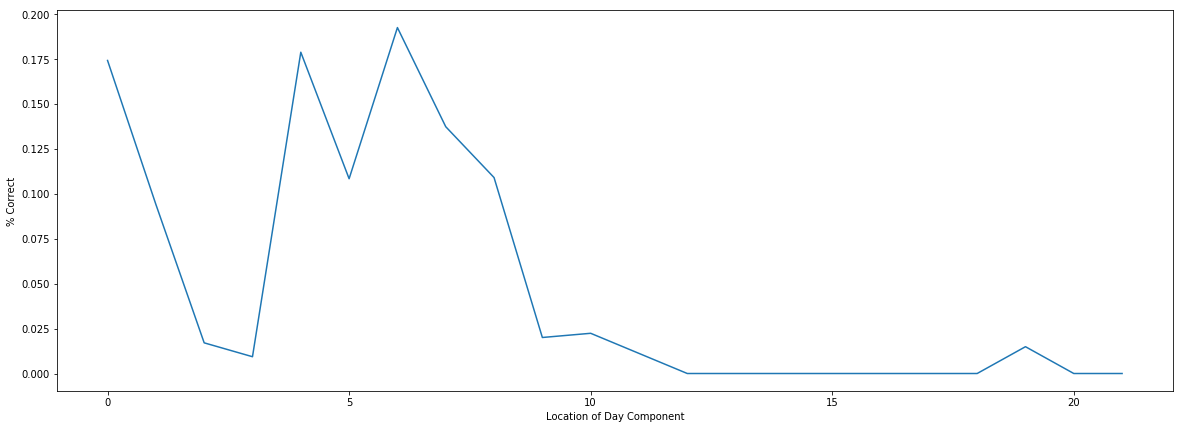

In [46]:
if not df['Is Correct'].any():
    print("Please re-train the model!")
else:
    ax = pd.crosstab(df['Day Location'], df['Is Correct'], normalize='index')[True].plot(kind='line', figsize=(20,7))
    ax.set_ylabel("% Correct")
    ax.set_xlabel("Location of Day Component");

Here too it would appear that the model has difficulties the further away the day component is from the beginning of the input. 

Naturally, an interesting question to ask is how correlated the day component location and input length are.  Are we actually looking at the same problem?

In [47]:
# Generate the Spearman correlation coefficient between the input source length and location of the day component.
print("Spearman correlation coefficient: ", np.corrcoef(df['Source Length'], df['Day Location'])[0][1])


Spearman correlation coefficient:  0.7562277395175759


We see that there is a fair bit of correlation, but the two factors are not identical.  We can therefore conclude that the model does best on 'easy' cases where it knows precisely where every part of the human-readable date is.  If we add in some form of 'noise' - for example, moving the day or year, using a full month name or adding superfluous components such as week day names - the model gets 'confused'.  Ideally, we would like a mechanism whereby the model can *focus* or *concentrate*.  In other words - the model will recognize the day, month and year no matter where they appear in the input and ignore parts of the input that do not affect the results.

Will will now see how to do this using the concept of *attention*.

# Improving Results Using Attention

In order to explain the concept of attention, we'll try a little exercise.  Look around you and pick some object like a light switch or a chair.  Look at the object for a few seconds and focus on it completely.  Notice how this object stays sharp in your field of view, while other objects seem to just fade into the background.  Also, note that this fading is gradual - things that are closer to your object are sharper while things further away are not.

This, in a nutshell, is attention - the ability to concentrate on what's relevant and ignore that which is irrelevant for the task at hand.  In Deep Learning, attention is a technique which is used to help the model focus - at every timestep - on only the relevant inputs.  For our purposes, it is the ability to focus on specific tokens while ignoring the rest.  To be more precise, we'll be using *soft-attention* - that is, we will not ignore tokens completely but rather assign them *weights* that determine how much the model should focus on them at any moment in time.



## Attention Models

<img src="images/NMT_Components.png" style="width:600;height:300px;"> <br>
<caption><center> **Figure 3**: Attention NMT model</center></caption>

As we've seen, we input the human-readable date to the encoder's Bi-LSTM network and take the resulting state vectors as the input to the decoder.  What we would like to do is - for every character in the output (that is for every timestep of the decoder) - have the model focus on the state vector that is most helpful *right now*.  Adding an attention block between the encoder and decoder does just that.

<img src="images/Attention_mechanism.png" style="width:600;height:300px;"> <br>
<caption><center> **Figure 4**: Attention Implementation</center>
    <center><i><a href='https://arxiv.org/abs/1409.0473'>Source: Dmzimtry Bahdanau, Kyung Hyun Cho and Yoshua Bengio, Neural Machine Translation by Jointly Learning to Align and Translate</a> </i> </center>
</caption>



In the above figure we can see the details of the attention block.  Each hidden state $h_i$ is composed of the combined output of the forwards and backwards LSTM (i.e., a Bi-LSTM). Furthermore, each such state has an associated weight at each timestep (the $\alpha_t$ values). This weighted sum of the states, along with the hidden state of the decoder network at time $t-1$, along with the output of the decoder at $t-1$, are used to calculate the output of the decoder at time $t$.  $\alpha_t$'s are calculated using an *alignment model*, which learns which encoder state ($h_j$) is relevant at what point in the decoder.


Attention is a general mechanism - the above is one way of implementing this 'focusing' behavior, known as *Bahdanau Attention*.  Another popular implementation is described [here](https://arxiv.org/abs/1508.04025) and is known as *Luong Attention*.  

While the concept of attention is not difficult to describe, its technical implementation is not trivial.  Rather than implementing it ourselves, we'll use ready-made implementations that are freely available in NVIDIA's open-source Seq2Seq toolkit, appropriately named Open Seq2Seq.

## Applying Open Seq2Seq to the Dates Problem


[Open Seq2Seq](https://github.com/NVIDIA/OpenSeq2Seq) is a Tensorflow-based toolkit for sequence-to-sequence problems that use the encoder-decoder architecture.  It contains models for machine translation, as well as speech-to-text, text-to-speech and image captioning.  As part of these models, Open Seq2Seq provides generic implementation for various types of encoders, decoders, loss functions and attention mechanism implementations.  

In order to work with Open Seq2Seq, we need the following files:
* Source sequences - Each line in this file contains a source sequence to be used as input.  In our case, this is the human-readable date.  
* Target sequences - Each line in this file contains a target sequence to be used as the required output.  In our case, this is the machine-readable date.  
* Source vocabulary - The individual tokens that make up the source sequences.  In our case - since we are 'translating' individual characters - these will be individual letters, numbers and symbols.  In more general cases, this vocabulary will contain individual words.  Note that this vocabulary also contains several special tokens for marking padding, beginning and end-of-sentence tokens.
* Target vocabulary - The individual tokens that make up the target sequences.  In our case, these will be numbers and the dash symbol, along with the special tokens described above.

The following code generates all of the required files in the `dates` directory.  We create source and target files for both a training and a test set.  An interesting implementation detail is the way we split our dates into individual characters:  since the whitespace character is a valid token in the human-readable date, we use the pipe symbol (|) as the delimiter between characters.

Run the following code, and inspect the files that are generated in the `dates` directory.

In [56]:
import os
if not os.path.exists('./dates'):
    os.makedirs('./dates')


def save_data(filename, data):
    with open('dates/' + filename + '.txt', 'w') as f:
        for x in data:
            f.write(x)
            f.write("\n")
            
save_data('source_train', map(lambda x: '|'.join(x[0]), dataset[:8000]))
save_data('target_train', map(lambda x: '|'.join(x[1]), dataset[:8000]))
save_data('source_test', map(lambda x: '|'.join(x[0]), dataset[8000:]))
save_data('target_test', map(lambda x: '|'.join(x[1]), dataset[8000:]))
save_data('source_vocab', [key for key,value in sorted(human_vocab.items(), key=lambda x: x[1])])
save_data('target_vocab', [key for key,value in sorted(machine_vocab.items(), key=lambda x: x[1])])



As part of its distribution, Open Seq2Seq provides a generic execution engine that can be configured for the appropriate use-case.  Open the `dates_config.py` - you can see that the configuration is in fact a set of python dictionaries that define model type and architecture.

In particular, note the following sections in the configuration:

*  `base_params` - This section defines parameters such as the number of GPUs to use for training, the number of epochs, the optimizer and learning rate and when to print statistics and/or save temporary models.
*  `encoder` - This section defines the encoder part of the architecture.  In our case, we use an encoder that contains a Bi-LSTM with Embedding, with the layer count as well as the LSTM and embedding sizes that match our hand-coded model from above.
*  `decoder` - This section defines the decoder part of the architecture.  In our case, we use a decoder that contains a regular LSTM with Bahdanau attention.  In addition to the number of layers and LSTM and embedding sizes, you can also the definition of the special tokens we described in the vocabulary section above.  
*  `train_params` - This section defines the source of the training data.  Here you can find the source and target sequences as well as the vocabulary files and the delimiter definition.
* `infer_params` - This section defines the model used during inference, as opposed to training.  Note that we use a different decoder during inference - rather than just an LSTM and attention, we also apply Beam Search (see below) to find the best sequence. Other than that, the changes from the previous sections are around the use of different source and target sequence files.

For completeness, it should also be mentioned that there is also an `eval_params` section that can be used to perform evaluation during and/or after training.  We will use it a little later on.

Run the following code to train the model using attention.  Notice the train loss values, as well as the sample source, target and prediction texts that the model displays as it's running.  We are using the same parameters as before, but now the model should rapidly converge.  

(Note:  if you'd like to run this multiple times, uncomment the following cell and run it so that it deletes the `dates_log` directory before each training run.)

In [58]:
!rm -rf ./dates_log

In [59]:
%%time

run_open_seq2seq(
    new_run, 
    '--config_file=dates_config.py --mode=train')

*** Starting training from scratch
*** Training config:
{'batch_size_per_gpu': 128,
 'data_layer': <class 'open_seq2seq2.data.text2text.text2text.ParallelTextDataLayer'>,
 'data_layer_params': {'delimiter': '|',
                       'map_parallel_calls': 16,
                       'max_length': 60,
                       'prefetch_buffer_size': 2,
                       'repeat': True,
                       'shuffle': True,
                       'source_file': 'dates/source_train.txt',
                       'src_vocab_file': 'dates/source_vocab.txt',
                       'target_file': 'dates/target_train.txt',
                       'tgt_vocab_file': 'dates/target_vocab.txt'},
 'decoder': <class 'open_seq2seq2.decoders.rnn_decoders.RNNDecoderWithAttention'>,
 'decoder_params': {'END_SYMBOL': 1,
                    'GO_SYMBOL': 2,
                    'PAD_SYMBOL': 0,
                    'attention_layer_size': 128,
                    'attention_type': 'bahdanau',
              

We have trained the model using 80% of the data in our original toy dataset.  We will now run inference on the remaining 20% and apply the same metrics as before - namely, whether the sequences are correct or not and how correctness varies with input length. 

In order to perform inference we use the same configuration as before, setting the `mode` parameter to *infer* rather than *train*.  The output of inference is written to a file named `infer-out.txt`.  Run the following three cells in order and compare the resulting plot to the one generated by the hand-coded model.  

In [60]:
%%time

run_open_seq2seq(
    new_run, 
    '--config_file=dates_config.py --mode=infer')

*** Restoring from the latest checkpoint
*** Loading model from dates_log/model.ckpt-2480
*** Inference config:
{'batch_size_per_gpu': 1,
 'data_layer': <class 'open_seq2seq2.data.text2text.text2text.ParallelTextDataLayer'>,
 'data_layer_params': {'delimiter': '|',
                       'map_parallel_calls': 16,
                       'max_length': 60,
                       'prefetch_buffer_size': 2,
                       'repeat': False,
                       'shuffle': False,
                       'source_file': 'dates/source_test.txt',
                       'src_vocab_file': 'dates/source_vocab.txt',
                       'target_file': 'dates/source_test.txt',
                       'tgt_vocab_file': 'dates/target_vocab.txt'},
 'decoder': <class 'open_seq2seq2.decoders.rnn_decoders.BeamSearchRNNDecoderWithAttention'>,
 'decoder_params': {'END_SYMBOL': 1,
                    'GO_SYMBOL': 2,
                    'PAD_SYMBOL': 0,
                    'attention_layer_size': 128,


In [61]:
df = pd.concat([
    pd.DataFrame(dataset[8000:], columns=['Source', 'Target']), 
    pd.read_csv('infer-out.txt', names=['Actual'], header=None) 
], axis=1)
df['Actual'] = df['Actual'].str.replace(' ','')
df['Is Correct'] = df['Actual'] == df['Target']
df['Source Length'] = df['Source'].apply(lambda x: len(x))



print("Accuracy: {}".format(df['Is Correct'].sum() / len(df)))
df.head()

Accuracy: 1.0


,Source,Target,Actual,Is Correct,Source Length
0,31.10.05,2005-10-31,2005-10-31,True,8
1,4 Jul 1981,1981-07-04,1981-07-04,True,10
2,"may 15, 1982",1982-05-15,1982-05-15,True,12
3,"Wednesday, July 3, 2019",2019-07-03,2019-07-03,True,23
4,"9 April, 2002",2002-04-09,2002-04-09,True,13


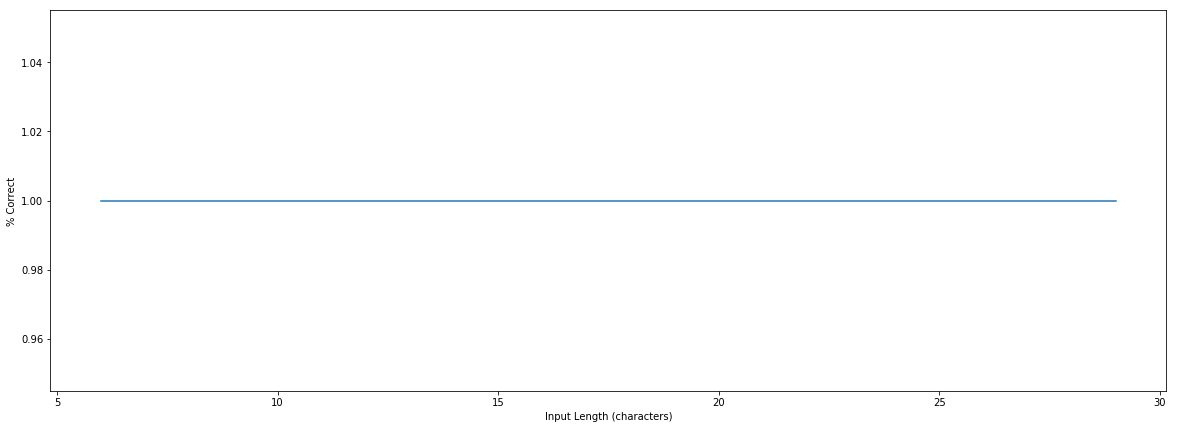

In [62]:
if not df['Is Correct'].any():
    print("Please re-train the model!")
else:
    ax = pd.crosstab(df['Source Length'], df['Is Correct'], normalize='index')[True].plot(kind='line', figsize=(20,7))
    ax.set_ylabel("% Correct")
    ax.set_xlabel("Input Length (characters)");

## A Better Score Metric

As discussed above, we use a character-by-character comparison to measure the date translation problem's accuracy.  For this problem, such a measure of success is sensible, as there is only one possible output 'translation'.  When dealing with real-world machine translation tasks, however, measuring results in this way is not a good idea.  To illustrate why, let's consider a slight modification on our date translation problem.

In our problem statement, we wish to translate from a human-readable format to a *specific* machine readable format, namely YYYY-MM-dd.  Similarly, we could have used a different format, such as dd-MM-YYYY.  So for a date such as 'January 12, 1984' we could have several translations.  For example:

* 1984-01-12 (YYYY-MM-dd)
* 12-01-1984 (dd-MM-YYYY)
* 1984-12-01 (YYYY-dd-MM)

or any other such variant.  Unless stated explicitly, all machine-readable formats can be considered to be equally good translations.  Naturally, this applies even more strongly to human language: different people may translate the same source-language sentence to multiple variants in the target language.  Can we distinctly say which one is 'better' or 'worse'?  For example, here are some English translations of a Chinese sentence (taken from the original BLEU paper - see below):

* It is a guide to action that ensures that the military will forever heed Party commands.
* It is the guiding principle which guarantees the military forces always being under the command of the Party.
* It is the practical guide for the army always to heed the directions of the party.

We can see that a better metric is needed for measuring machine translation results than just plain 'is this character in the right spot'.  This metric is known as the [Bilingual Evaluation Understudy](https://en.wikipedia.org/wiki/BLEU), or BLEU, score.  We will implement BLEU below.  For now, let's get some intuition on the BLEU scores for our toy problem.  In the process, we'll also get to see some more features of Open Seq2Seq.

__Exercise__:  Open the file `dates_eval_config.py` and complete the missing pieces in the `eval_params` section.  Use the *test* versions of the source and target files. Run the following cells to re-train the model and observe the BLEU scores during training.  A completed file is available in `dates_eval_config.py.solution`.

In [63]:
!rm -rf ./dates_eval_log

In [64]:
%%time

run_open_seq2seq(
    new_run, 
    '--config_file=dates_eval_config.py --mode=train_eval')

*** Starting training from scratch
*** Training config:
{'batch_size_per_gpu': 128,
 'data_layer': <class 'open_seq2seq2.data.text2text.text2text.ParallelTextDataLayer'>,
 'data_layer_params': {'delimiter': '|',
                       'map_parallel_calls': 16,
                       'max_length': 60,
                       'prefetch_buffer_size': 2,
                       'repeat': True,
                       'shuffle': True,
                       'source_file': 'dates/source_train.txt',
                       'src_vocab_file': 'dates/source_vocab.txt',
                       'target_file': 'dates/target_train.txt',
                       'tgt_vocab_file': 'dates/target_vocab.txt'},
 'decoder': <class 'open_seq2seq2.decoders.rnn_decoders.RNNDecoderWithAttention'>,
 'decoder_params': {'END_SYMBOL': 1,
                    'GO_SYMBOL': 2,
                    'PAD_SYMBOL': 0,
                    'attention_layer_size': 128,
                    'attention_type': 'bahdanau',
              

***     *****EVAL Source[0]:     <s>|A|U|G|U|S|T|<unk>|2|7|<unk>|1|9|9|0|<eos>
***     *****EVAL Target[0]:     <s>|1|9|9|0|-|0|8|-|2|7|<eos>
***     *****EVAL Prediction[0]: 8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8
***     *****EVAL Source[0]:     <s>|o|c|t|o|b|e|r|<unk>|5|<unk>|2|0|1|7|<eos>
***     *****EVAL Target[0]:     <s>|2|0|1|7|-|1|0|-|0|5|<eos>
***     *****EVAL Prediction[0]: 8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8
***     *****EVAL Source[0]:     <s>|1|8|<unk>|J|U|N|E|<unk>|1|9|9|3|<eos>
***     *****EVAL Target[0]:     <s>|1|9|9|3|-|0|6|-|1|8|<eos>
***     *****EVAL Prediction[0]: 8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8|8
***     *****EVAL Source[0]:     <s>|0|7|.|0|2|.|9|3|<eos>
***     *****EVAL Target[0]:     <s>|1|9|9|3|-|0|2|-|0|7

***     *****EVAL Source[0]:     <s>|T|u|e|s|d|a|y|,|<unk>|O|c|t|o|b|e|r|<unk>|2|6|,|<unk>|1|9|9|9|<eos>
***     *****EVAL Target[0]:     <s>|1|9|9|9|-|1|0|-|2|6|<eos>
***     *****EVAL Prediction[0]: 1|9|9|9|-|2|1|-|2|1|-|2|1|-|2|1|-|2|1|-|2|1|-|2|1|-|2|1|-|2|1|-|2|1|-|2|1|-|2|1|-|2|1|-|2|1|-|2|1|-|2|1|-|2|1|-|2|1|-|2
***     Validation loss: 12.6195 
***     Eval BLUE score: 0.0522
*** Epoch 8, global step 500: ***     Train loss: 11.0227 
time per step = 0:00:0.100
***     Train Source[0]:     <s>|0|4|,|<unk>|J|u|n|<unk>|2|0|1|7|<eos>
***     Train Target[0]:     <s>|2|0|1|7|-|0|6|-|0|4|<eos>
***     Train Prediction[0]: 0|0|1|7|-|0|6|-|0|6|-|6
*** Running evaluation on a validation set:
***     *****EVAL Source[0]:     <s>|3|1|.|1|0|.|0|5|<eos>
***     *****EVAL Target[0]:     <s>|2|0|0|5|-|1|0|-|3|1|<eos>
***     *****EVAL Prediction[0]: 0|0|0|5|-|1|0|-|1|1|<eos>
***     *****EVAL Source[0]:     <s>|1|4|<unk>|M|A|Y|,|<unk>|1|9|8|4|<eos>
***     *****EVAL Target[0]:     <s>|1|9|8|4

***     *****EVAL Source[0]:     <s>|J|a|n|u|a|r|y|<unk>|2|3|,|<unk>|1|9|7|8|<eos>
***     *****EVAL Target[0]:     <s>|1|9|7|8|-|0|1|-|2|3|<eos>
***     *****EVAL Prediction[0]: 1|9|7|8|-|0|1|-|2|3|<eos>
***     *****EVAL Source[0]:     <s>|1|0|<unk>|j|u|l|y|<unk>|2|0|0|1|<eos>
***     *****EVAL Target[0]:     <s>|2|0|0|1|-|0|7|-|1|0|<eos>
***     *****EVAL Prediction[0]: 2|0|0|1|-|0|7|-|1|0|<eos>
***     *****EVAL Source[0]:     <s>|A|U|G|U|S|T|<unk>|2|7|<unk>|1|9|9|0|<eos>
***     *****EVAL Target[0]:     <s>|1|9|9|0|-|0|8|-|2|7|<eos>
***     *****EVAL Prediction[0]: 1|9|9|0|-|0|8|-|2|7|<eos>
***     *****EVAL Source[0]:     <s>|o|c|t|o|b|e|r|<unk>|5|<unk>|2|0|1|7|<eos>
***     *****EVAL Target[0]:     <s>|2|0|1|7|-|1|0|-|0|5|<eos>
***     *****EVAL Prediction[0]: 2|0|1|7|-|1|0|-|0|5|<eos>
***     *****EVAL Source[0]:     <s>|1|8|<unk>|J|U|N|E|<unk>|1|9|9|3|<eos>
***     *****EVAL Target[0]:     <s>|1|9|9|3|-|0|6|-|1|8|<eos>
***     *****EVAL Prediction[0]: 1|9|9|3|-|0|6|-|1|8|<eos>

In the above output, look for lines marked with 'Eval BLUE score'.  Observe how that score increases during the training run.

# Real Use Case




We now have a better understanding of what attention can be used for.  Next we will try an actual Neural Machine Translation model for translating from German to English.

But first, we need to discuss an important point in Machine Translation as well as other NLP tasks:  BPE representation.

### BPE
BPE stands for byte pair encoding. It means that common byte pairs - bigrams of characters in our case - are replaced by a byte which never occurs in the corpus. For example, in our corpus we have never seen the "#" char so we could use it to represent some typical bigram like "ie". In practice, however, all the printable characters are used, so we use the unprintable part of the codepage for BPE.  In order actually print the text, we need to reformat it back. So you'll see "@@" in text - these are artifacts from such renormalization.

Here is an example text in German, which will be translated in English by our model.

In [65]:
!head /dli/data/wmt/newstest2015.tok.bpe.32000.de

Die Premierminister Indi@@ ens und Japans tra@@ fen sich in Tok@@ io .
Indi@@ ens neuer Premierminister Nar@@ end@@ ra Mo@@ di trifft bei seinem ersten wichtigen Auslands@@ besu@@ ch seit seinem Wahl@@ sie@@ g im Mai seinen japanischen Amts@@ kol@@ legen Shin@@ zo A@@ be in Tok@@ o , um wirtschaftliche und sicherheits@@ politische Beziehungen zu bes@@ prechen .
Herr Mo@@ di befindet sich auf einer fünf@@ tä@@ gigen Reise nach Japan , um die wirtschaftlichen Beziehungen mit der d@@ ritt@@ größten Wirtschafts@@ nation der Welt zu festigen .
Pläne für eine stärkere kern@@ technische Zusammenarbeit stehen ganz oben auf der Tagesordnung .
Berichten zufolge ho@@ fft Indien darüber hinaus auf einen Vertrag zur Verteidigungs@@ zusammenarbeit zwischen den beiden Nationen .
Polizei von Kar@@ ra@@ tha verhaftet 20-@@ J@@ ähri@@ gen nach schneller Motor@@ rad@@ j@@ ag@@ d
Ein Motor@@ rad wurde besch@@ la@@ gn@@ ah@@ mt , nachdem der Fahrer es mit 125 km / h in einer 70 km / h-@@ Zone und durch Bu@


Let's see what our results are.

In [66]:
run_open_seq2seq(
    old_run, 
    '--config_file=old_s2s/example_configs/nmt.json --logdir=/dli/data/nmt --mode=infer --inference_out=pred.txt')

>==================> Running in inference mode
>==================> Executing training mode
>==================> Creating data layer
>==================> Data layer created
>==================> Building graph on GPU:0
Inference Mode. Loss part of graph isn't built.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
>==================> Trying to restore from: /dli/data/noatt/model-59244
INFO:tensorflow:Restoring parameters from /dli/data/noatt/model-59244
>==================> Saving inference results to: baseline.txt
Prime Minister India and Japan met in Tokyo . </S> </S> </S>
Federal Government and Bun@@ de@@ stag not joined . </S> </S> </S> </S> </S> </S> </S> </S> </S> </S> </S> </S> </S> </S> </S> </S> </S> </S> </S>
I wonder him if he will ever make a booth up com@@ ed@@ y@@ tour . </S> </S> </S> </S> </S>
A@@ il@@ inn Sol@@ om@@ ons was a delicate beauty with un@@ attended hair and a flat heart from a village on

KeyboardInterrupt: 

Open up [pred.txt](pred.txt) to compare to [baseline.txt](baseline.txt) to see the difference attention makes in the overall quality of the translation. Training with more epochs will improve and possibly to get to the translation that you've identified as the best in the first part of the lab. 

## Assessment - BLEU score

In this final part, you are going to implement the Bilingual Evaluation Understudy, or BLUE, Score to assess the effectiveness of translations as a ratio. Completely mismatched results will be scored as 0.0, and the perfect translation will be scored as 1.0. There are various formulas applied to sentence, corpus or any length translation, but it's meant to be a good proxy to compare various implementations. Our date translation examples are simple, but BLEU score is also meant to encapsulate how a human would rate the translation for language translations.

<img src="images/BLEU.png" style="width:600;height:300px;">

The BLEU could be described as the overlap of single tokens and sequences of tokens (2, 3 or 4) - this is $precision_i$.
And also brevity penalty of $\frac{output-length}{reference - length}$ is applied in the formula.

We will split each ground truth to one character at a time and also the predicted value. BLEU score works on the 1-4 ngrams so we need to supply at least 4 ngrams in our predictions. If we had a string 2007-07-11, we can split it into tokens 2007, 07 and 11. For exact matches, the score is 1.0 but for small variations like one character off, it makes the score lower than it should be. We will call this string score implemented in `str_score`.

Alternatively, we can convert it to list of ['2', '0', '0', '7', '-', '0', '7', '-', '1', '1'] by making a token of every single character, including dashes to get the higher score. It should be implemented in `char_score`. Let's compare the two implementations and the BLEU scores they calculate.

For your reference: parameters for sentence_bleu function are as follows:	
references (list(list(str))) – A list of reference translations<br>
hypothesis (list(str)) – A hypothesis translation

### Generate the right BLEU scores

Change the code for how the strings are being prepared and compared in [my_bleu.py](../../../../edit/tasks/task3/task/my_bleu.py) for both type of BLEU score calculations. Save your changes to fix BLEU score calculation.

Hint: Look at the actual output compared to the expected reference/output on which BLEU score is being checked

In [76]:
# Test your implementation
# Kernel->restart will ensure the latest version of my_bleu.py is imported if you made any changes to the code to re-test

import my_bleu as mb

output1 = '2007-07-11<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'
expected = '2007-07-11'

print(mb.str_score(output1, expected))    #expecting 1.0
print(mb.char_score(output1, expected)) # expecting 1.0

output2 = '2007-07-12<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>' #it's 12 instead of 011

print(mb.str_score(output2, expected))    #expecting 0.7598356856515925
print(mb.char_score(output2, expected)) #expecting 0.8801117367933934

0.006737946999085467
0.006737946999085467
0.005930146235786944
0.005930146235786944


# [Optional] Experiment with Beam Search

As we've seen, attention changes the probability of which character to focus on in a given sequence. There are other strategies we can apply to improve the results of the translation. Beam search is one such popular heuristic. It works by returning a list of output *sequences* that are most likely for a given input. It does this by exploring all of the possible next steps, and then chooses the most promising $k$ candidates from all possibilities. Those candidates form a 'beam' of directions, where the algorithm expands the search through each candidate's sequence of probabilities. 

The larger the beam, the better the performance of the model. Since there are more candidate sequences this means the likelihood of finding the right answer increases. However, it requires more decoding, meaning a direct tradeoff with the quality of results versus accuracy. Seeding beam search with the most likely next words in a sequence can yield good results. The beam search would generate the resulting sequence, starting from the first word and appending, while exploring all the candidates (size of the beam) every step of the way.

We have started the beginning of beam search to generate samples with the following code:

In [68]:
m = model_simple_nmt(len(human_vocab), len(machine_vocab))

m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(m.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 20)                0         
_________________________________________________________________
Embedding_Layer (Embedding)  (None, 20, 64)            3968      
_________________________________________________________________
Encoder (Bidirectional)      (None, 20, 64)            24832     
_________________________________________________________________
Decoder (LSTM)               (None, 20, 32)            12416     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 15)            495       
Total params: 41,711
Trainable params: 41,711
Non-trainable params: 0
_________________________________________________________________
None


In [69]:
inputs, targets = zip(*dataset)
inputs = np.array([string_to_int(i, 20, human_vocab) for i in inputs])
targets = [string_to_int(t, 20, machine_vocab) for t in targets]
targets = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), targets)))

In [70]:
m.fit([inputs], targets, epochs=1, batch_size=64, validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/1
9000/9000 [==============================] - 17s 2ms/step - loss: 1.4407 - acc: 0.5634 - val_loss: 1.0408 - val_acc: 0.6407


In [71]:
def keras_rnn_predict(samples, empty=human_vocab["<pad>"], rnn_model=m, maxlen=30):
    """for every sample, calculate probability for every possible label
    you need to supply your RNN model and maxlen - the length of sequences it can handle
    """
    data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty)
    return rnn_model.predict(data, verbose=0)

Here we'll try to generate some dates from our model to demonstrate beam search properties:

In [72]:
def beamsearch(predict=keras_rnn_predict, k=1, maxsample=10, 
               use_unk=False, 
               oov=human_vocab["<unk>"], 
               empty=human_vocab["<pad>"], 
               eos=human_vocab["<unk>"]):
    """return k samples (beams) and their NLL scores, each sample is a sequence of labels,
    all samples starts with an `empty` label and end with `eos` or truncated to length of `maxsample`.
    You need to supply `predict` which returns the label probability of each sample.
    `use_unk` allow usage of `oov` (out-of-vocabulary) label in samples
    """
    
    dead_k = 0 # samples that reached eos
    dead_samples = []
    dead_scores = []
    live_k = 1 # samples that did not yet reached eos
    live_samples = [[empty]]
    live_scores = [0]

    while live_k and dead_k < k:
        # for every possible live sample calc prob for every possible label 
        probs = predict(live_samples, empty=empty)

        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        cand_flat = cand_scores.flatten()

        # find the best (lowest) scores we have from all possible samples and new words
        ranks_flat = cand_flat.argsort()[:(k-dead_k)]
        live_scores = cand_flat[ranks_flat]

        # append the new words to their appropriate live sample
        voc_size = probs.shape[1]
        live_samples = [live_samples[r//voc_size]+[r%voc_size] for r in ranks_flat]

        # live samples that should be dead are...
        zombie = [s[-1] == eos or len(s) >= maxsample for s in live_samples]
        
        # add zombies to the dead
        dead_samples += [s for s,z in zip(live_samples,zombie) if z]  # remove first label == empty
        dead_scores += [s for s,z in zip(live_scores,zombie) if z]
        dead_k = len(dead_samples)
        # remove zombies from the living 
        live_samples = [s for s,z in zip(live_samples,zombie) if not z]
        live_scores = [s for s,z in zip(live_scores,zombie) if not z]
        live_k = len(live_samples)

    return live_samples + dead_samples, live_scores + dead_scores

# Summary

In this lab, we discussed the use of Deep Learning for performing Machine Learning.  We experimented with a simple problem of converting dates from a human to a machine-readable form.  We then improved the model using attention. Finally, we explored the use of beam search.

In this lab we focus on *supervised* Machine Translation.  This directly implies that we need labeled corpora.  However, for languages with little or no labeled data, this is very unlikely.  A fascinating avenue of research is the use of *unsupervised* MT, which does not require such corpora.    

Machine Translation is an enabling tool to bring various people and cultures around the world closer together.  The tools and techniques you have seen in this lab can help make this a reality.  

__Acknowledgements__: 

The idea of date translation is borrowed from https://github.com/datalogue/keras-attention.



<img src="images/DLI Header.png" alt="Header" style="width: 400px;"/>